In [110]:
import os
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
import copy

from ReadMaestro import maestro
from ReadMaestro import parse_pursuit_trials
paths = [p for p in sys.path if os.path.exists(p)]
print(paths)

from importlib import reload
reload(maestro)
reload(parse_pursuit_trials)

['/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '/home/seth/.local/lib/python3.9/site-packages', '/usr/local/lib/python3.9/dist-packages', '/usr/lib/python3/dist-packages']


<module 'ReadMaestro.parse_pursuit_trials' from '/home/seth/analysis/ReadMaestro/ReadMaestro/parse_pursuit_trials.py'>

In [2]:
#file_path = '/home/seth/Projects/DynamicCoherencePhysiology/ar/20220404a/ar220404a.0001'
#with open(file_path, 'rb') as f:
#    data_file = maestro.DataFile.load(f.read(), file_path)

In [35]:
instrument_data = maestro.load_directory('/home/seth/Projects/DynamicCoherencePhysiology/test/20191118b')
instrument = parse_pursuit_trials.pursuitDataObject()
instrument.setName(instrument_data)
print(instrument.name)

instrument.pursuitData(instrument_data,trialIDs=['dPref'], directions=[], speeds=[], coherences=[], perturbations=[]);

instrumentNoise = (np.var(instrument.hvelocities) + np.var(instrument.vvelocities))/2
print(instrumentNoise)

/home/seth/Projects/DynamicCoherencePhysiology/test/20191118b
0.4754257839211303


In [3]:
data = maestro.load_directory('/home/seth/Projects/DynamicCoherencePhysiology/ar/20220404a')

In [111]:
purs = parse_pursuit_trials.pursuitDataObject()
# purs.__init__(purs)
purs.setName(data)
print(purs.name)

purs.pursuitData(data,trialIDs=['initCoh'], directions=[0.0,45.0,90.0,135.0,180.0,225.0,270.0,315.0], speeds=[5.0,10.0,20.0], coherences=[100.0], perturbations=[]);
purs.applyRotationToData()

purs_permute = copy.deepcopy(purs)
purs_permute.permuteSaccades()

purs.setSaccadeVelocitiesToNaN()
purs.scaleVelocities()

purs_permute.setSaccadeVelocitiesToNaN()
purs_permute.scaleVelocities()

/home/seth/Projects/DynamicCoherencePhysiology/ar/2022040


Text(0, 0.5, 'Horizontal velocity (deg/s)')

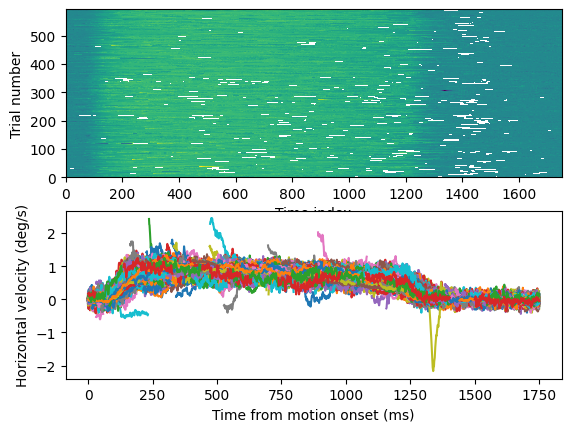

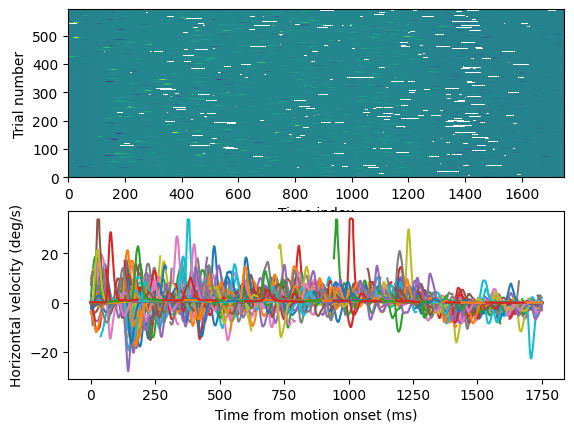

In [37]:
%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].pcolor(purs.hvelocities.T);
axes[0].set_ylabel('Trial number')
axes[0].set_xlabel('Time index')

axes[1].plot(purs.eye_t,purs.hvelocities);
axes[1].set_xlabel('Time from motion onset (ms)')
axes[1].set_ylabel('Horizontal velocity (deg/s)')

fig2, axes2 = plt.subplots(nrows=2, ncols=1)
axes2[0].pcolor(purs_permute.hvelocities.T);
axes2[0].set_ylabel('Trial number')
axes2[0].set_xlabel('Time index')

axes2[1].plot(purs_permute.eye_t,purs_permute.hvelocities);
axes2[1].set_xlabel('Time from motion onset (ms)')
axes2[1].set_ylabel('Horizontal velocity (deg/s)')

In [51]:
mu, C = purs.computeMeanCov(purs.hvelocities)

print(np.shape(C))
print(np.shape(mu))

[[            nan             nan  8.43995958e-18 ...  5.90797170e-18
   1.10268000e-01  1.65402000e-01]
 [            nan             nan  9.18900000e-03 ... -9.18900000e-03
   1.28646000e-01  1.47024000e-01]
 [            nan             nan             nan ... -2.75670000e-02
   1.10268000e-01  1.65402000e-01]
 ...
 [ 2.75670000e-02             nan             nan ...  1.37835000e-02
  -1.83780000e-02 -1.83780000e-02]
 [ 4.59450000e-02             nan             nan ... -4.59450000e-03
  -7.35120000e-02 -1.83780000e-02]
 [ 5.51340000e-02             nan             nan ... -2.29725000e-02
  -5.51340000e-02 -5.51340000e-02]]
(1751, 1751)
(1751,)


Text(0, 0.5, 'Mean horizontal velocity (deg/s)')

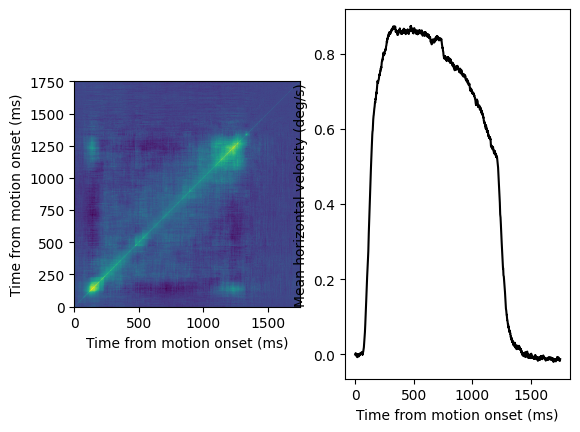

In [52]:

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].pcolor(C);
axes[0].set_aspect('equal', 'box')
axes[0].set_xlabel('Time from motion onset (ms)')
axes[0].set_ylabel('Time from motion onset (ms)')

axes[1].plot(purs.eye_t,mu,'k')
axes[1].set_xlabel('Time from motion onset (ms)')
axes[1].set_ylabel('Mean horizontal velocity (deg/s)')

In [119]:
x = purs.hvelocities[:,-55]
y = np.logical_not(np.isnan(x))
f = x[y]
print(np.mean(purs.speeds))
print(instrumentNoise)
mu_, C_, C_UnObs, C_ObsObs = purs.conditionalGaussian(mu,np.array(C),f,x_indices=y,obsNoise=instrumentNoise/np.mean(purs.speeds),nearSPD=False)


11.666666666666666
0.4754257839211303


Text(0, 0.5, 'Horizontal velocity - mean (deg/s)')

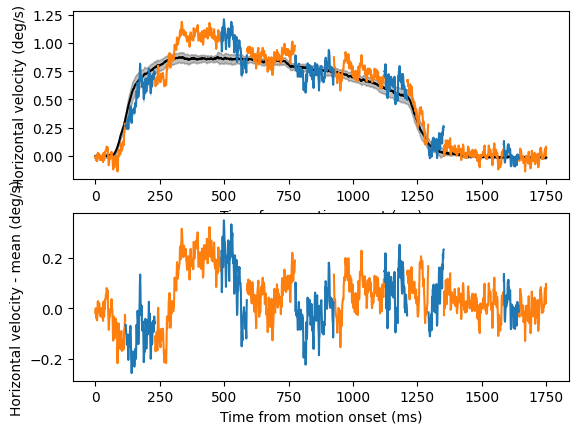

In [120]:
%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].plot(purs.eye_t,mu,'k')
lb = mu - np.diag(np.array(C))*1.96
ub = mu + np.diag(np.array(C))*1.96
axes[0].fill_between(purs.eye_t,lb,ub, color='k',alpha=0.25)
axes[0].plot(purs.eye_t,x,'tab:orange')
temp = np.empty_like(mu)
temp[y] = np.nan
temp[np.logical_not(y)] = mu_
lb = np.empty_like(mu)
lb[y] = np.nan
lb[np.logical_not(y)] = mu_ - np.diag(C_)*1.96
ub = np.empty_like(mu)
ub[y] = np.nan
ub[np.logical_not(y)] = mu_ + np.diag(C_)*1.96
axes[0].plot(purs.eye_t,temp,'tab:blue')
axes[0].fill_between(purs.eye_t,lb,ub, color='tab:blue',alpha=0.25)
axes[0].set_xlabel('Time from motion onset (ms)')
axes[0].set_ylabel('Horizontal velocity (deg/s)')

axes[1].plot(purs.eye_t,x-mu,'tab:orange')
axes[1].plot(purs.eye_t,temp-mu,'tab:blue')
axes[1].set_xlabel('Time from motion onset (ms)')
axes[1].set_ylabel('Horizontal velocity - mean (deg/s)')

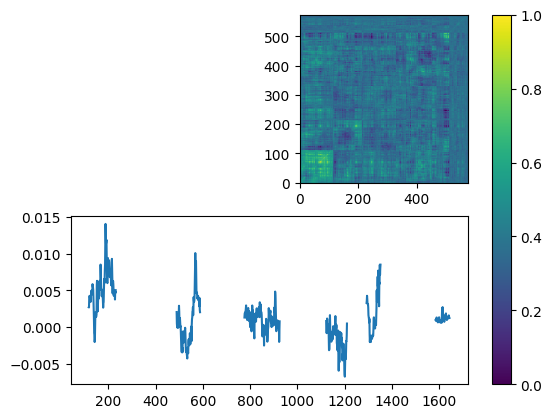

In [57]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].pcolor(C_)
axes[0].set_aspect('equal', 'box')
fig.colorbar(plt.cm.ScalarMappable(), ax=axes)
axes[0].set_aspect('equal', 'box')

temp = np.empty_like(mu)
temp[y] = np.nan
temp[np.logical_not(y)] = np.diag(C_)
axes[1].plot(purs.eye_t,temp)
# axes[1].pcolor(C_ObsObs)
# axes[1].set_aspect('equal', 'box')
# axes[2].pcolor(C_UnObs @ np.linalg.inv(C_ObsObs))
# axes[2].set_aspect('equal', 'box')
# fig.colorbar(plt.cm.ScalarMappable(), ax=axes[2])
# axes[3].pcolor(C_)
# axes[3].set_aspect('equal', 'box')

In [58]:
# Test conditionalGaussian
Ntest = 100
Sig = np.ones((Ntest,Ntest))
for i in range(Ntest):
    for j in range(Ntest):
        Sig[i,j] = np.exp( -(i-j)**2/100 )

#Sig = Sig + 0.0005*np.identity(Ntest)

mu_test = np.zeros((Ntest,))
x = np.random.multivariate_normal(mu_test,Sig)
print(x.shape)

t = np.arange(Ntest)
y = np.ones_like(mu_test, dtype=bool)
y[0:10] = False
q = sum(y)
f = x[y]
# muObs = mu_test[y]
# muUn = mu_test[np.logical_not(y)]

# SigUnUn = Sig[0:Ntest-q,0:Ntest-q]
# SigUnObs = Sig[0:Ntest-q,Ntest-q:]
# SigObsObs = Sig[Ntest-q:,Ntest-q:] + 0.0000001*np.identity(q)
# SigObsUn = Sig[Ntest-q:,0:Ntest-q]

# temp = SigUnObs @ np.linalg.inv(SigObsObs)
# mu_ = muUn + temp @ (f-muObs)
mu_, a, b, c = purs.conditionalGaussian(mu_test,Sig,f,x_indices=y,obsNoise=0.0000001)
print(mu_)

(100,)
(90,)
(10, 90)
[-1.64912277 -1.72221113 -1.77291634 -1.8045619  -1.82136413 -1.8270962
 -1.82381321 -1.8109854  -1.78530825 -1.74129339]


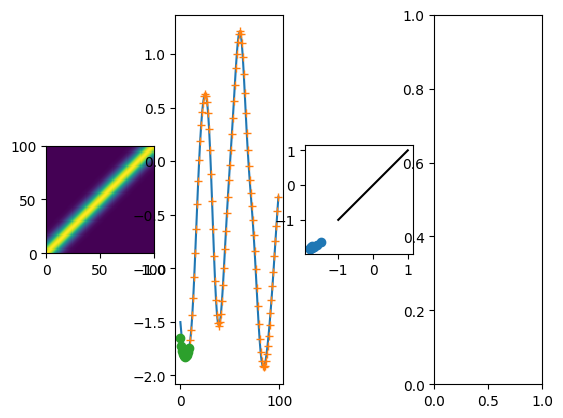

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=4)
axes[0].pcolor(Sig)
axes[0].set_aspect('equal', 'box')
#axes[1].pcolor(SigUnObs)
#axes[1].set_aspect('equal', 'box')
#axes[2].pcolor(SigObsObs)
#xes[2].set_aspect('equal', 'box')
#axes[3].pcolor(temp.T)
axes[1].plot(t,x)
axes[1].plot(t[y],f,'+')
axes[1].plot(t[np.logical_not(y)],mu_,'o')
#axes[2].plot(t[y],f-muObs)
axes[2].plot(x[np.logical_not(y)],mu_,'o')
axes[2].plot([-1,1],[-1,1],'k')
axes[2].set_aspect('equal', 'box')


(-0.4, 0.4)

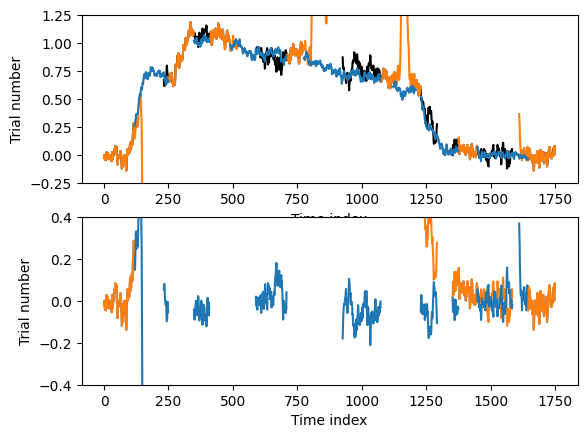

In [121]:
triali = -55
x = purs_permute.hvelocities[:,triali]
y = np.logical_not(np.isnan(x) + np.isnan(purs.hvelocities[:,triali]))
f = x[y]
mu_, C_, C_UnObs, C_ObsObs = purs.conditionalGaussian(mu,np.array(C),f,x_indices=y,obsNoise=instrumentNoise/np.mean(purs.speeds),nearSPD=False)

temp = np.empty_like(mu)
temp[y] = np.nan
temp[np.logical_not(y)] = mu_

fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].plot(purs_permute.eye_t,purs.hvelocities[:,triali],'k')
axes[0].plot(purs_permute.eye_t,purs_permute.hvelocities[:,triali],'tab:orange')
axes[0].plot(purs.eye_t,temp,'tab:blue')
axes[0].set_ylabel('Trial number')
axes[0].set_xlabel('Time index')
axes[0].set_ylim(-0.25, 1.25)

axes[1].plot(purs.eye_t,purs_permute.hvelocities[:,triali],purs.hvelocities[:,triali],'tab:orange')
axes[1].plot(purs.eye_t,temp - purs.hvelocities[:,triali],'tab:blue')
axes[1].set_ylabel('Trial number')
axes[1].set_xlabel('Time index')
axes[1].set_ylim(-0.4, 0.4)

In [123]:
x = purs_permute.hvelocities[:,:10]
y = np.logical_not(np.isnan(x) + np.isnan(purs.hvelocities[:,:10]))
f = x[y]
print(y.shape)
print(f.shape)
mu_, C_, C_UnObs, C_ObsObs = purs.conditionalGaussian(mu,np.array(C),f,x_indices=y,obsNoise=instrumentNoise/np.mean(purs.speeds),nearSPD=False)

(1751, 10)
(6257,)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed